In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('SMSSpamCollection.csv')
df.head()

,Class,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   5572 non-null   object
 1   sms     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
df['sms'] = df['sms'].apply(lambda x: str(x).lower())

In [6]:
import nltk
from nltk.corpus import stopwords

In [7]:
stop_words = stopwords.words('english')

def remove_stopwords(txt):
    txt = ' '.join(word for word in txt.split(' ') if word not in stop_words)
    return txt

df['sms'] = df['sms'].apply(remove_stopwords)

In [8]:
df.head()

,Class,sms
0,ham,"go jurong point, crazy.. available bugis n gre..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,u dun say early hor... u c already say...
4,ham,"nah think goes usf, lives around though"


In [9]:
df['Class'] = df['Class'].replace({'spam':1, 'ham':0})

### WordCloud

In [10]:
from wordcloud import WordCloud

In [11]:
msgs = ''
for msg in df[df['Class']==0]['sms']:
    msg = msg.split(' ')
    for words in msg:
        msgs = msgs+words+' '

wcloud0 = WordCloud().generate(msgs)

msgs = ''
for msg in df[df['Class']==1]['sms']:
    msg = msg.split(' ')
    for words in msg:
        msgs = msgs+words+' '

wcloud1 = WordCloud().generate(msgs)

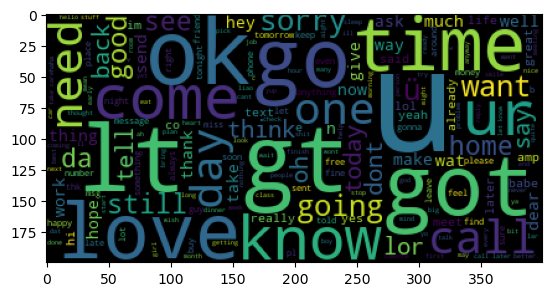

In [12]:
plt.imshow(wcloud0)
plt.show()

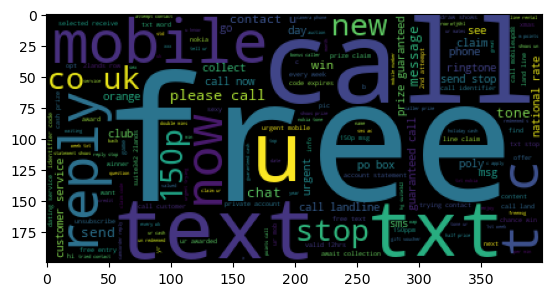

In [13]:
plt.imshow(wcloud1)
plt.show()

### Predict Spam - Count Vectorizer

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [15]:
y = df['Class']
X = df.sms
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
cvect = CountVectorizer()

In [17]:
cvect = CountVectorizer()
X_traint = cvect.fit_transform(X_train)
X_testt = cvect.transform(X_test)

In [18]:
type(X_traint)

scipy.sparse._csr.csr_matrix

In [19]:
X_traint.shape

(3900, 7236)

In [23]:
list(cvect.vocabulary_.items())[0:5]

[('quite', 5182), ('late', 3744), ('lar', 3738), ('ard', 969), ('12', 260)]

In [104]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

mnb = MultinomialNB()
mnb.fit(X_traint, y_train)

y_train_pred = mnb.predict(X_traint)
y_train_prob = mnb.predict_proba(X_traint)[:,1]

print('Confusion matrix - Train:  ', '\n', confusion_matrix(y_train, y_train_pred))
print('Accuracy score - Train:  ', '\n', accuracy_score(y_train, y_train_pred))
print('AUC score: ', '\n', roc_auc_score(y_train, y_train_prob))

y_test_pred = mnb.predict(X_testt)
y_test_prob = mnb.predict_proba(X_testt)[:,1]

print('Confusion matrix - test:  ', '\n', confusion_matrix(y_test, y_test_pred))
print('Accuracy score - test:  ', '\n', accuracy_score(y_test, y_test_pred))
print('AUC score - test: ', '\n', roc_auc_score(y_test, y_test_prob))

Confusion matrix - Train:   
 [[3366   11]
 [  11  512]]
Accuracy score - Train:   
 0.9943589743589744
AUC score:  
 0.9974056872182819
Confusion matrix - test:   
 [[1438   10]
 [  12  212]]
Accuracy score - test:   
 0.9868421052631579
AUC score - test:  
 0.9857808800315707


#### Draw AUC curve

In [105]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
thresholds[0] = thresholds[0]-1
roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
roc.iloc[80:90,:]

,fpr,tpr,thresholds
80,0.279696,0.982143,0.001954
81,0.308011,0.982143,0.001287
82,0.309392,0.982143,0.001282
83,0.312845,0.982143,0.001195
84,0.314227,0.982143,0.001183
85,0.321133,0.982143,0.001010
86,0.322514,0.982143,0.001004
87,0.328729,0.982143,0.000908
88,0.330110,0.982143,0.000898
89,0.390193,0.982143,0.000380


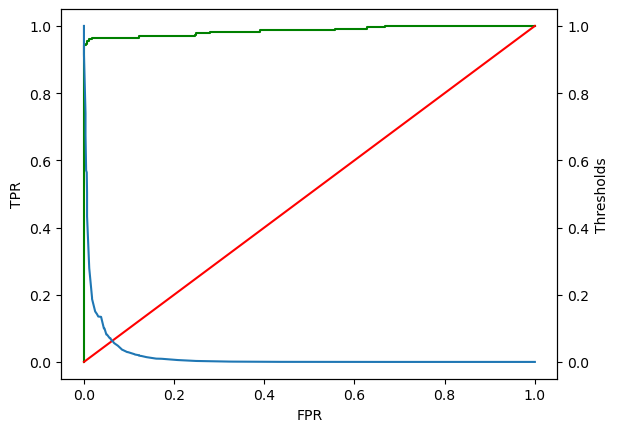

In [106]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, 'g')
ax.plot(fpr, fpr, 'r')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax2 = ax.twinx()
ax2.plot(fpr, thresholds)
ax2.set_ylabel('Thresholds')
plt.show()

### Predict Spam - TfIdf

In [107]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_traint)
X_test_tfidf = tfidf.transform(X_testt)

In [108]:
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)

y_train_pred = mnb.predict(X_train_tfidf)
y_train_prob = mnb.predict_proba(X_train_tfidf)[:,1]

print('Confusion matrix - Train:  ', '\n', confusion_matrix(y_train, y_train_pred))
print('Accuracy score - Train:  ', '\n', accuracy_score(y_train, y_train_pred))
print('AUC score: ', '\n', roc_auc_score(y_train, y_train_prob))

y_test_pred = mnb.predict(X_test_tfidf)
y_test_prob = mnb.predict_proba(X_test_tfidf)[:,1]

print('Confusion matrix - test:  ', '\n', confusion_matrix(y_test, y_test_pred))
print('Accuracy score - test:  ', '\n', accuracy_score(y_test, y_test_pred))
print('AUC score - test: ', '\n', roc_auc_score(y_test, y_test_prob))

Confusion matrix - Train:   
 [[3377    0]
 [  77  446]]
Accuracy score - Train:   
 0.9802564102564103
AUC score:  
 0.9976372616241576
Confusion matrix - test:   
 [[1448    0]
 [  42  182]]
Accuracy score - test:   
 0.9748803827751196
AUC score - test:  
 0.9854602407261247


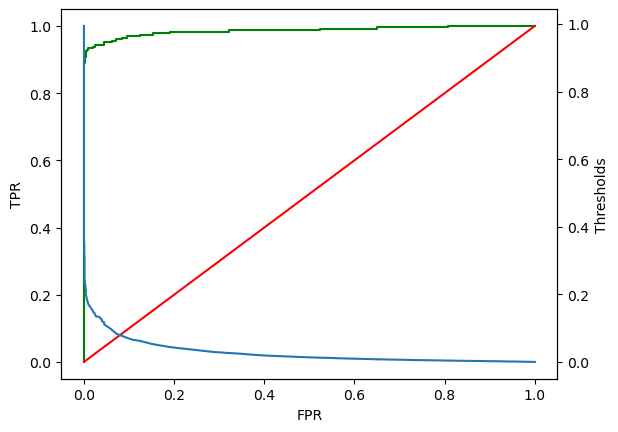

In [109]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
thresholds[0] = thresholds[0]-1
roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})

fig, ax = plt.subplots()
ax.plot(fpr, tpr, 'g')
ax.plot(fpr, fpr, 'r')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax2 = ax.twinx()
ax2.plot(fpr, thresholds)
ax2.set_ylabel('Thresholds')
plt.show()

In [10]:
(6*7.2)/30

1.4400000000000002

In [11]:
1.44-1.2

0.24

0.2